<a href="https://colab.research.google.com/github/madrigaljose/CycleGAN/blob/master/20210622_Madrigal_FinalProject_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective of the project is to predict the price of John Deere Stock, different approaches and hypothesis will be evaluated, and a recommendation will be made as to what model / approach works better for this purpose** 

In [1]:
!pip install pandas-datareader
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 13.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=06d7875e576aab62096f2d6d4082ab3cb7e0f28b0255a609a45387c80ce0d717
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_pfp9lg/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [29]:
# for data input and output:
import numpy as np
import os
import pandas as pd

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new! 

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


#################
import tensorflow as tf
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers

import pandas_datareader.data as pdr
import yfinance as yf

In [3]:
#Reading latest Deere Stock data from Yahoo Finance
yf.pdr_override()
DE = pdr.get_data_yahoo('DE')
DE['DE_Close'] = DE[['Adj Close']]  
DE=DE[['DE_Close']]

[*********************100%***********************]  1 of 1 completed


In [4]:
#Reading commodities price from Github, commodities originally downloaded from Koyfin, but a couple of weeks ago, it changed to a paywall, so the last csv's that I was able to download 
#were added to my github account.
#same code will be used below for reading 4 commodities files
Corn = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Corn.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Corn=Corn.set_axis(['Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Corn=Corn.dropna()
Cotton = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Cotton.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Cotton=Cotton.set_axis(['Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Cotton=Cotton.dropna()
Wheat = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Wheat.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Wheat=Wheat.set_axis(['Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Wheat=Wheat.dropna()
Soy = pd.read_csv('https://raw.githubusercontent.com/madrigaljose/madrigaljose/main/koyfin_Soy.csv',parse_dates=[' Date'],index_col=' Date',thousands=',')
Soy=Soy.set_axis(['Open','Low','High','Close','SMA50D','SMA200D'], axis='columns').rename_axis('Date')
Soy=Soy.dropna()

## missing values are dropped as well, for ease of data manipulation later on.

In [5]:
#Code to Inspecting the 5 data frames
DE.info()
DE
#Corn.info()
#Corn
#Cotton.info()
#Cotton
#Soy.info()
#Soy
#Wheat.info()
#Wheat

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12393 entries, 1972-06-01 to 2021-07-22
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DE_Close  12393 non-null  float64
dtypes: float64(1)
memory usage: 193.6 KB


,DE_Close
Date,
1972-06-01,0.691186
1972-06-02,0.704633
1972-06-05,0.701944
1972-06-06,0.695220
1972-06-07,0.687151
...,...
2021-07-16,342.489990
2021-07-19,334.950012
2021-07-20,348.029999


In [6]:
#To preserve the original DF, I'll copy the values on new df, that way, for future models, the original information can be reused without any compromise or loss
DE_df=DE
###############################Use below for SMA200D
Corn_df= Corn[['SMA200D']].rename(columns={"SMA200D":"Corn_Input"})
Soy_df= Soy[['SMA200D']].rename(columns={"SMA200D":"Soy_Input"})
Wheat_df= Wheat[['SMA200D']].rename(columns={"SMA200D":"Wheat_Input"})
Cotton_df= Cotton[['SMA200D']].rename(columns={"SMA200D":"Cotton_Input"})
###############################Use below for using the 'Open' price
#Corn_df= Corn[['Open']].rename(columns={"Open":"Corn_Input"})
#Soy_df= Soy[['Open']].rename(columns={"Open":"Soy_Input"})
#Wheat_df= Wheat[['Open']].rename(columns={"Open":"Wheat_Input"})
#Cotton_df= Cotton[['Open']].rename(columns={"Open":"Cotton_Input"})

In [9]:
Corn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14051 entries, 1935-10-01 to 2021-06-25
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Corn_Input  14051 non-null  float64
dtypes: float64(1)
memory usage: 219.5 KB


In [10]:
df1=Corn_df.join(Cotton_df, how='inner').join(Soy_df, how='inner').join(Wheat_df, how='inner').join(DE_df, how='inner')
df1.info()
df1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10304 entries, 1978-07-07 to 2021-06-24
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Corn_Input    10304 non-null  float64
 1   Cotton_Input  10304 non-null  float64
 2   Soy_Input     10304 non-null  float64
 3   Wheat_Input   10304 non-null  float64
 4   DE_Close      10304 non-null  float64
dtypes: float64(5)
memory usage: 483.0 KB


,Corn_Input,Cotton_Input,Soy_Input,Wheat_Input,DE_Close
Date,,,,,
1978-07-07,234.18,284.63,627.43,57.28,1.709103
1978-07-10,234.37,284.99,628.18,57.33,1.729369
1978-07-11,234.54,285.34,628.86,57.36,1.769900
1978-07-12,234.69,285.65,629.60,57.41,1.749635
1978-07-13,234.85,285.96,630.31,57.46,1.756390
...,...,...,...,...,...
2021-06-18,520.61,634.91,1315.47,78.03,328.123810
2021-06-21,522.12,635.59,1317.52,78.13,337.010895
2021-06-22,523.59,636.28,1319.39,78.23,341.220032


In [16]:
df1.describe()

,Corn_Input,Cotton_Input,Soy_Input,Wheat_Input,DE_Close
count,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000
mean,314.756408,422.134616,771.444415,68.677713,37.480363
std,117.449086,137.965343,255.580212,16.395537,56.790942
min,161.610000,253.250000,454.650000,35.440000,1.453617
25%,236.042500,327.950000,581.690000,59.210000,3.524290
50%,272.825000,375.915000,685.350000,66.085000,12.992323
75%,366.312500,492.600000,913.247500,75.662500,59.246207
max,742.470000,898.530000,1528.590000,157.570000,393.205963


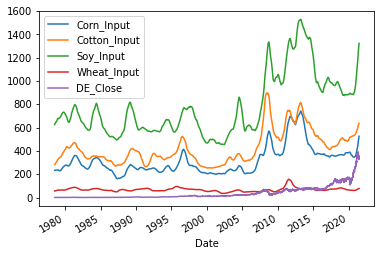

In [11]:
df1.plot()
plt.show()

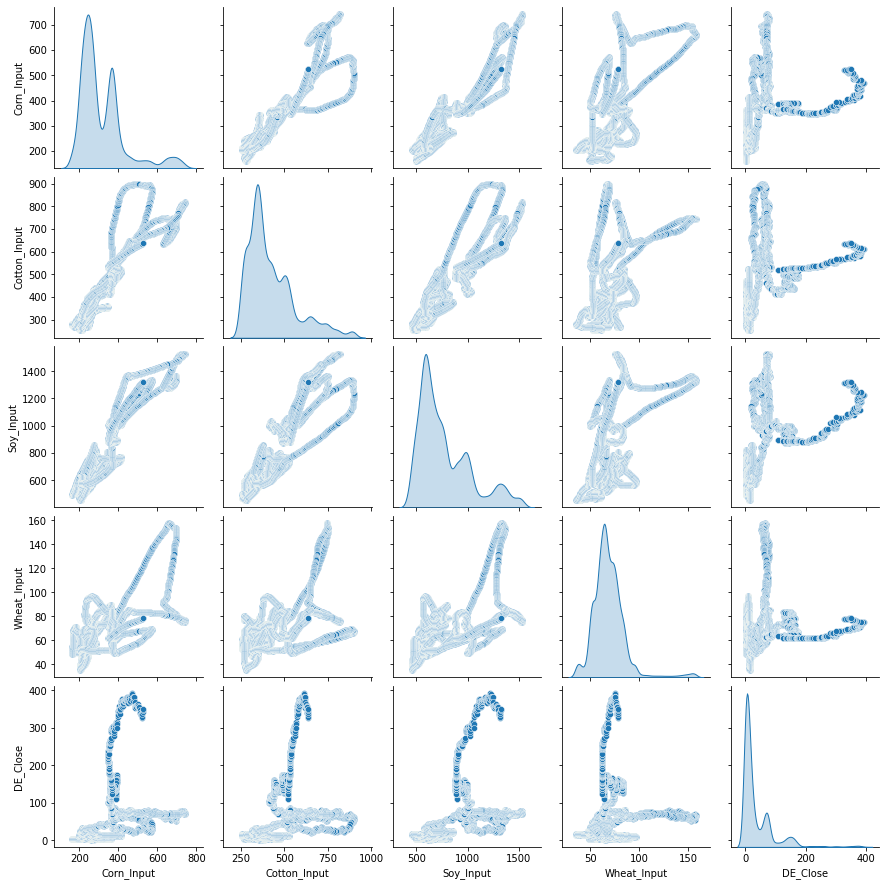

In [14]:
sns.pairplot(df1[['Corn_Input','Cotton_Input','Soy_Input','Wheat_Input','DE_Close']], diag_kind="kde")
plt.show()

RNN **(DRAFT)**

In [64]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.models import Sequential



In [65]:
#create training and test set
train = df1[:'2019'].iloc[:,0:1].values
valid  = df1['2020':].iloc[:,0:1].values
train_len = len(train)
valid_len = len(valid)
train.shape, valid.shape

((9931, 1), (373, 1))

In [70]:
##TimeSteps
time_steps=60
for_periods=2
#Scaling the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
train_scaled = scaler.fit_transform(train)

# create training data of s samples and t time steps
X_train = []
y_train = []
y_train_stacked = []
for i in range(time_steps,train_len-1): 
    X_train.append(train_scaled[i-time_steps:i,0])
    y_train.append(train_scaled[i:i+for_periods,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))



In [71]:
inputs = pd.concat((df1[:'2019'], df1['2020':]),axis=0).values
inputs = inputs[len(inputs)-len(valid) - time_steps:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

# Preparing X_test
X_test = []
for i in range(time_steps,valid_len+time_steps-for_periods):
    X_test.append(inputs[i-time_steps:i,0])
        
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


In [72]:
    #create single layer rnn model trained on X_train and y_train
    #and make predictions on the X_test data
        
my_rnn_model = Sequential()
my_rnn_model.add(SimpleRNN(32, return_sequences=True))
#my_rnn_model.add(SimpleRNN(32, return_sequences=True))
#my_rnn_model.add(SimpleRNN(32, return_sequences=True))
my_rnn_model.add(SimpleRNN(32))
my_rnn_model.add(Dense(2)) # The time step of the output

my_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the RNN model
my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=1)

# Finalizing predictions
rnn_predictions = my_rnn_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)





Epoch 1/100
66/66 [==============================] - 5s 30ms/step - loss: 0.0611
Epoch 2/100
66/66 [==============================] - 2s 30ms/step - loss: 2.3773e-04
Epoch 3/100
66/66 [==============================] - 2s 30ms/step - loss: 7.6905e-05
Epoch 4/100
66/66 [==============================] - 2s 30ms/step - loss: 4.5126e-05
Epoch 5/100
66/66 [==============================] - 2s 30ms/step - loss: 2.9149e-05
Epoch 6/100
66/66 [==============================] - 2s 28ms/step - loss: 2.3327e-05
Epoch 7/100
66/66 [==============================] - 2s 28ms/step - loss: 1.9203e-05
Epoch 8/100
66/66 [==============================] - 2s 30ms/step - loss: 1.5931e-05
Epoch 9/100
66/66 [==============================] - 2s 29ms/step - loss: 1.5223e-05
Epoch 10/100
66/66 [==============================] - 2s 30ms/step - loss: 1.2558e-05
Epoch 11/100
66/66 [==============================] - 2s 31ms/step - loss: 1.3778e-05
Epoch 12/100
66/66 [==============================] - 2s 29ms/step 

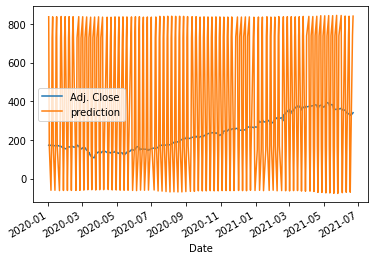

In [73]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = DE_df.loc['2020':,'DE_Close'][0:len(rnn_predictions)]
actual_pred['prediction'] = rnn_predictions[:,0]

from keras.metrics import MeanSquaredError
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
m.result().numpy() 
actual_pred.plot()

In [ ]:
#my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
#rnn_predictions_2[1:10]
#actual_pred_plot(rnn_predictions_2)   

In [31]:
lags = 30
train_generator = TimeseriesGenerator(train, train, length=lags, batch_size=5)
valid_generator = TimeseriesGenerator(valid, valid, length=lags, batch_size=1)

In [40]:
model = Sequential()
model.add(SimpleRNN(32, dropout=0.2, input_shape=(lags, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_generator, epochs=10, verbose=1, validation_data=valid_generator)




Epoch 1/10
2031/2031 [==============================] - 16s 7ms/step - loss: 0.0072 - val_loss: 0.0107
Epoch 2/10
2031/2031 [==============================] - 13s 6ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 3/10
2031/2031 [==============================] - 13s 6ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 4/10
2031/2031 [==============================] - 13s 6ms/step - loss: 0.0016 - val_loss: 0.0127
Epoch 5/10
2031/2031 [==============================] - 12s 6ms/step - loss: 0.0014 - val_loss: 0.0150
Epoch 6/10
2031/2031 [==============================] - 12s 6ms/step - loss: 5.8972e-04 - val_loss: 0.0042
Epoch 7/10
2031/2031 [==============================] - 12s 6ms/step - loss: 4.8389e-04 - val_loss: 0.0104
Epoch 8/10
2031/2031 [==============================] - 13s 6ms/step - loss: 8.3846e-04 - val_loss: 0.0120
Epoch 9/10
2031/2031 [==============================] - 12s 6ms/step - loss: 3.2795e-04 - val_loss: 0.0127
Epoch 10/10
2031/2031 [==============================] - 

In [42]:
# Finalizing predictions
rnn_predictions = model.predict(valid)
rnn_predictions = sc.inverse_transform(rnn_predictions)

ValueError: ignored

In [ ]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)  

Initial model, will try to predict the value of Deere stock, based on the Moving Average of the commodities, 200D used to allow for the offset of price realization in a good season and the equipment sales the next spring, initial theory is that a good price in a season, increases sales the next season thus boosting the stock.